#  Recurrent PG Crypto-Currency Trading

In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [6]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [249]:
class RPG_Crypto_portfolio(object):
    def __init__(self, feature_number, action_size=1, hidden_units_number=[128, 64], learning_rate=0.001):
        tf.reset_default_graph()
        self.s = tf.placeholder(dtype=tf.float32, shape=[None, feature_number], name='s')
        self.a = tf.placeholder(dtype=tf.int32, shape=[None,action_size], name='a')
        self.r = tf.placeholder(dtype=tf.float32, shape=[None], name='r')
        self.s_next=tf.placeholder(dtype=tf.float32, shape=[None, feature_number], name='s_next')
        self.action_size=action_size
        self.a_buffer = []
        self.r_buffer = []
        self.s_buffer = []
        self.s_next_buffer=[]
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32, shape=[], name='dropout_keep_prob')
        with tf.variable_scope('rnn_encoder', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            cell=self._add_GRU(units_number=128,keep_prob=self.dropout_keep_prob)
            self.rnn_input=tf.expand_dims(self.s,axis=0)
            self.rnn_output,_=tf.nn.dynamic_rnn(inputs=self.rnn_input,cell=cell,dtype=tf.float32)
            self.rnn_output=tf.unstack(self.rnn_output,axis=0)[0]
            
        with tf.variable_scope('supervised',initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.state_predict = self._add_dense_layer(inputs=self.rnn_output, output_shape=[feature_number], drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.reward_predict = self._add_dense_layer(inputs=self.rnn_output, output_shape=[1], drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.state_loss=tf.losses.mean_squared_error(self.state_predict,self.s_next)
            self.reward_loss=tf.losses.mean_squared_error(self.reward_predict,tf.expand_dims(self.r,axis=0))
            
        with tf.variable_scope('policy_gradient',initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.a_prob = self._add_dense_layer(inputs=self.rnn_output, output_shape=hidden_units_number, drop_keep_prob=self.dropout_keep_prob, act=tf.nn.relu, use_bias=True)
            self.a_prob = self._add_dense_layer(inputs=self.a_prob, output_shape=[action_size], drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.a_out = tf.nn.softmax(self.a_prob,axis=-1)
            self.negative_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.a_out, labels=self.a)
            
        with tf.variable_scope('train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.loss = tf.reduce_mean(self.negative_cross_entropy * self.r)+tf.reduce_mean(self.state_loss)+tf.reduce_mean(self.reward_loss)
            self.train_op = optimizer.minimize(self.loss)
        self.init_op = tf.global_variables_initializer()
        self.session = tf.Session()
        self.saver = tf.train.Saver()
    def init_model(self):
        self.session.run(self.init_op)
    
    def _add_dense_layer(self, inputs, output_shape, drop_keep_prob, act=tf.nn.relu, use_bias=True):
        output = inputs
        for n in output_shape:
            output = tf.layers.dense(output, n, activation=act, use_bias=use_bias)
            output = tf.nn.dropout(output, drop_keep_prob)
        return output
    
    def _add_GRU(self,units_number,activation=tf.nn.relu,keep_prob=1.0):
        cell = tf.contrib.rnn.GRUCell(units_number,activation=activation)
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
        return cell
    
    def _add_gru_cell(self, units_number, activation=tf.nn.relu):
        return tf.contrib.rnn.GRUCell(num_units=units_number, activation=activation)
    
    def train(self, drop=0.85):
#         np.random.shuffle(random_index)
        feed = {
            self.a: np.array(self.a_buffer),
            self.r: np.array(self.r_buffer),
            self.s: np.array(self.s_buffer),
            self.s_next:np.array(self.s_next_buffer),
            self.dropout_keep_prob: drop
        }
        _, loss = self.session.run([self.train_op, self.loss], feed_dict=feed)
        return loss
    
    def restore_buffer(self):
        self.a_buffer = []
        self.r_buffer = []
        self.s_buffer = []
        self.s_next_buffer=[]
    
    def save_current_state(self,s):
        self.s_buffer.append(s)
    
    def save_transation(self, a, r,s_next):
        self.a_buffer.append(a)
        self.r_buffer.append(r)
        self.s_next_buffer.append(s_next)
    
    def trade(self, s, train=False, drop=1.0):
        feed = {
            self.s: np.array(self.s_buffer),
            self.dropout_keep_prob: drop
        }
        a_prob = self.session.run([self.a_out], feed_dict=feed)
        a_prob = a_prob[0][-1].flatten()
        if train:
            a_indices = np.arange(a_prob.shape[0])
            target_index=np.random.choice(a_indices, p=a_prob)
            a=np.zeros(a_prob.shape[0])
            a[target_index]=1.0
            return a
        else:
            target_index=np.argmax(a_prob)
            a=np.zeros(a_prob.shape[0])
            a[target_index]=1.0
            return a

In [239]:
# assets=['kanbtc','mdsbtc','socbtc','xrpbtc','dbcbtc','eosbtc','wiccbtc','letbtc']
# assets=['kan','eos','mana']
# assets=['kan','wicc','edu','eos','let']
assets=assets=['ont', 'kan', 'mana', 'ht']

In [230]:
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='15min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data(x[1],close_name='close',high_name='high',low_name='low',open_name='open')),asset_data)
asset_data=dict(asset_data)
asset_data=pd.Panel(asset_data)

In [250]:
model=RPG_Crypto_portfolio(action_size=asset_data.shape[0]+1,feature_number=asset_data.shape[2]*asset_data.shape[0],learning_rate=1e-3)
model.init_model()
model.restore_buffer()

In [251]:
normalize_length=20
train_length=50
batch_size=20
c=0
epoch=30
train_r=[]
test_r=[]
for e in range(epoch):
    train_reward=[]
    test_reward=[]
    test_actions=[]
    for b in range(batch_size):
        previous_action=np.zeros(asset_data.shape[0]+1)
        for t in range(b*train_length+normalize_length,(b+1)*train_length+normalize_length):
            state=asset_data[:,t-normalize_length:t,:].values
            next_state=asset_data[:,t-normalize_length+1:t+1,:].values
            state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
            next_state=next_state.reshape((next_state.shape[1],next_state.shape[0]*next_state.shape[2]))
            state=z_score(state)[None,-1]
            next_state=z_score(next_state)[None,-1]
            model.save_current_state(s=state[0])
            action=model.trade(state,train=True)
            r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
            model.save_transation(a=action,r=r,s_next=next_state[0])
            previous_action=action
        loss=model.train()
        train_reward.append(np.sum(model.r_buffer))
        model.restore_buffer()
    model.restore_buffer()
    print(e,'train_reward',np.sum(train_reward))
    train_r.append(np.sum(train_reward))
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(train_length*batch_size+normalize_length,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length:t,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        model.save_current_state(s=state[0])
        action=model.trade(state,train=False)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        model.save_transation(a=action,r=r,s_next=None)
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action
        if t % train_length==0:
            model.restore_buffer()
    print(e,'test_reward',np.sum(test_reward))
    test_r.append(np.sum(test_reward))
    model.restore_buffer()
    if np.sum(np.sum(test_reward))>0.8: break
model.restore_buffer()

0 train_reward 0.17401002657697973
0 test_reward 0.2786421314181097
1 train_reward 0.026850525601275876
1 test_reward 0.15453551344626204
2 train_reward 0.3485536202424554
2 test_reward 0.11235807824664334
3 train_reward 0.28335910188661717
3 test_reward 0.05790845287333468
4 train_reward 0.09029016550857727
4 test_reward 0.048978487699969264
5 train_reward 0.1834565924091297
5 test_reward 0.10598471734942905
6 train_reward 0.5094257127307176
6 test_reward 0.02346532682486213
7 train_reward 0.5527579191370933
7 test_reward 0.016135257857513352
8 train_reward 0.33408453072297584
8 test_reward -0.12883227417341914
9 train_reward 0.5108807003380207
9 test_reward 0.03129989927401766
10 train_reward 0.5782363243265536
10 test_reward 0.04716669413755881
11 train_reward 0.7680737315454282
11 test_reward 0.2075033647406599
12 train_reward 0.8695900913808146
12 test_reward -0.03236568138026996
13 train_reward 0.933180432761219
13 test_reward 0.12907371270011936
14 train_reward 0.672540035521706

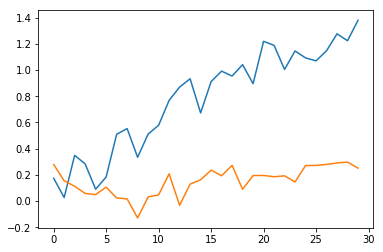

In [259]:
plt.plot(train_r)
plt.plot(test_r)

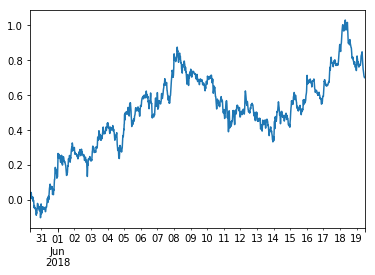

In [260]:
asset_data[:,:,'diff'].sum(axis=1).cumsum().plot()

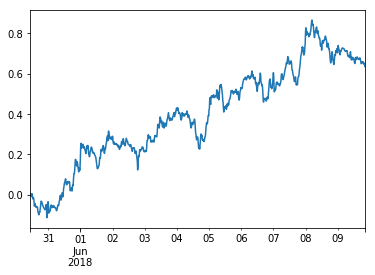

In [261]:
asset_data[:,normalize_length:train_length*batch_size+normalize_length,'diff'].sum(axis=1).cumsum().plot()

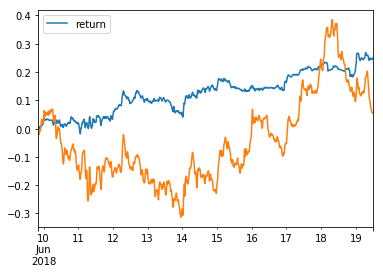

In [262]:
pd.DataFrame(test_reward,index=asset_data[:,train_length*batch_size+normalize_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length*batch_size+normalize_length:,'diff'].sum(axis=1).cumsum().plot()

In [256]:
np.sum(test_reward)

0.25075396486909085

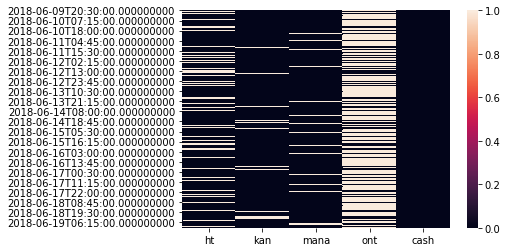

In [258]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length*batch_size+normalize_length:,'diff'].index,columns=list(asset_data.items)+['cash'])
sns.heatmap(test_action_df)